<a href="https://colab.research.google.com/github/nitishnarayanan002/Sales-Forecasting-for-Rosseman/blob/main/Capstone_Project_Rosemann_Sales_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Problem Statement

Rossmann operates thousands of drug stores across Europe.
Due to short shelf life of drugs, accurate daily sales forecasting is critical.

Objective

Forecast daily sales for the next 6 weeks (42 days) for 9 key stores:

1, 3, 8, 9, 13, 25, 29, 31, 46



**Why This Is a Time-Series Problem?**

*   Sales depend on past sales
*   Customers, promotions & holidays influence sales
*   Possible non-stationarity and long-run relationships

# Modeling Strategy

1.   Exploratory Data Analysis (EDA)
2.   Outlier treatment
3.   Univariate, bivariate & multivariate analysis
4.   Stationarity check (ADF Test)
5.   Cointegration check (Johansen Test)
6.   VAR / Differenced VAR modeling
7.   6-week forecast
8.   Evaluation using MAPE



## Import Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen

plt.style.use("seaborn-v0_8")


## Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
zip_path = "/content/drive/MyDrive/Dataset.zip"


In [4]:
import zipfile
import os

extract_path = "/content/rossmann_data"

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Files extracted to:", extract_path)


Files extracted to: /content/rossmann_data


In [5]:
os.listdir(extract_path)


['train.csv', 'store.csv']

## Load files

In [6]:
# Load CSV Files

train = pd.read_csv(
    os.path.join(extract_path, "train.csv"),
    parse_dates=["Date"]
)

store = pd.read_csv(
    os.path.join(extract_path, "store.csv")
)

print("Train shape:", train.shape)
print("Store shape:", store.shape)


/tmp/ipython-input-1282775583.py:3: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv(


Train shape: (1017209, 9)
Store shape: (1115, 10)


## Filter key stores

In [7]:
key_stores = [1, 3, 8, 9, 13, 25, 29, 31, 46]

train = train[train["Store"].isin(key_stores)]
store = store[store["Store"].isin(key_stores)]


In [8]:
## Merge meta data
df = train.merge(store, on="Store", how="left")
df.sort_values(["Store", "Date"], inplace=True)
df.reset_index(drop=True, inplace=True)


In [9]:
## Checking the top 10 Rows
train.head(10)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
7,8,5,2015-07-31,8492,833,1,1,0,1
8,9,5,2015-07-31,8565,687,1,1,0,1
12,13,5,2015-07-31,8821,568,1,1,0,0
24,25,5,2015-07-31,14180,1586,1,1,0,1
28,29,5,2015-07-31,9411,737,1,1,0,1
30,31,5,2015-07-31,7248,645,1,1,0,1
45,46,5,2015-07-31,7628,775,1,1,0,0
1115,1,4,2015-07-30,5020,546,1,1,0,1


In [10]:
#stores data
store.head(10)


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
7,8,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
8,9,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
24,25,c,a,430.0,4.0,2003.0,0,NaN,NaN,NaN
28,29,d,c,2170.0,NaN,NaN,0,NaN,NaN,NaN
30,31,d,c,9800.0,7.0,2012.0,0,NaN,NaN,NaN
45,46,c,a,1200.0,9.0,2005.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


In [11]:
## Data structure
store.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 0 to 45
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      9 non-null      int64  
 1   StoreType                  9 non-null      object 
 2   Assortment                 9 non-null      object 
 3   CompetitionDistance        9 non-null      float64
 4   CompetitionOpenSinceMonth  7 non-null      float64
 5   CompetitionOpenSinceYear   7 non-null      float64
 6   Promo2                     9 non-null      int64  
 7   Promo2SinceWeek            3 non-null      float64
 8   Promo2SinceYear            3 non-null      float64
 9   PromoInterval              3 non-null      object 
dtypes: float64(5), int64(2), object(3)
memory usage: 792.0+ bytes


In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8110 entries, 0 to 1016140
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Store          8110 non-null   int64         
 1   DayOfWeek      8110 non-null   int64         
 2   Date           8110 non-null   datetime64[ns]
 3   Sales          8110 non-null   int64         
 4   Customers      8110 non-null   int64         
 5   Open           8110 non-null   int64         
 6   Promo          8110 non-null   int64         
 7   StateHoliday   8110 non-null   object        
 8   SchoolHoliday  8110 non-null   int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 633.6+ KB


# Check for missing data

In [13]:
print("Missing values in Train dataset:")
train.isna().sum()


Missing values in Train dataset:


,0
Store,0
DayOfWeek,0
Date,0
Sales,0
Customers,0
Open,0
Promo,0
StateHoliday,0
SchoolHoliday,0


In [14]:
print("\nMissing values in Store dataset:")
store.isna().sum()



Missing values in Store dataset:


,0
Store,0
StoreType,0
Assortment,0
CompetitionDistance,0
CompetitionOpenSinceMonth,2
CompetitionOpenSinceYear,2
Promo2,0
Promo2SinceWeek,6
Promo2SinceYear,6
PromoInterval,6


###Impute missing values

In [15]:
# Promo interval is categorical → make missing explicit
store["PromoInterval"] = store["PromoInterval"].fillna("None")



In [16]:
# These NaNs represent "event never happened"
cols_to_keep_nan = [
    "CompetitionOpenSinceMonth",
    "CompetitionOpenSinceYear",
    "Promo2SinceWeek",
    "Promo2SinceYear"
]

store[cols_to_keep_nan].isna().sum()


,0
CompetitionOpenSinceMonth,2
CompetitionOpenSinceYear,2
Promo2SinceWeek,6
Promo2SinceYear,6


In [17]:
df = train.merge(store, on="Store", how="left")
df.sort_values(["Store", "Date"], inplace=True)
df.reset_index(drop=True, inplace=True)


### Remove closed Store Days

In [18]:
df = df[df["Open"] == 1]


### Outlier Treatment (99th Percentile) - As Extreme spikes distort time-series models like VAR.

In [19]:
sales_99 = df["Sales"].quantile(0.99)
cust_99 = df["Customers"].quantile(0.99)

df = df[
    (df["Sales"] <= sales_99) &
    (df["Customers"] <= cust_99)
]


# Exploratory Data Analysis

## Univariate Analysis

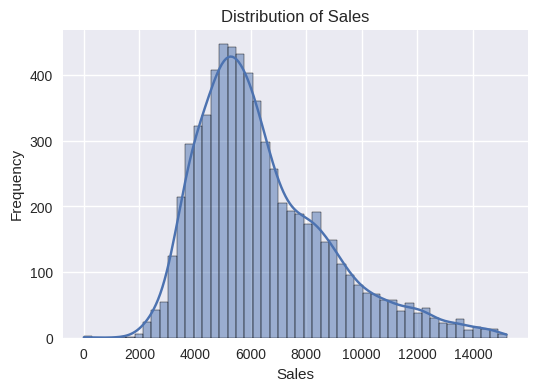

In [20]:
# Univariate Analysis
plt.figure(figsize=(6,4))
sns.histplot(df["Sales"], bins=50, kde=True)
plt.title("Distribution of Sales")
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.show()


**Sales Distribution**

From the histogram + KDE:

The distribution has a long right tail

Majority of observations are concentrated between ~3,000 to ~8,000

Few days have very high sales (10k–15k+)

**Conclusion**:
- Sales is right-skewed
-  Presence of high-value outliers
- Distribution is non-normal

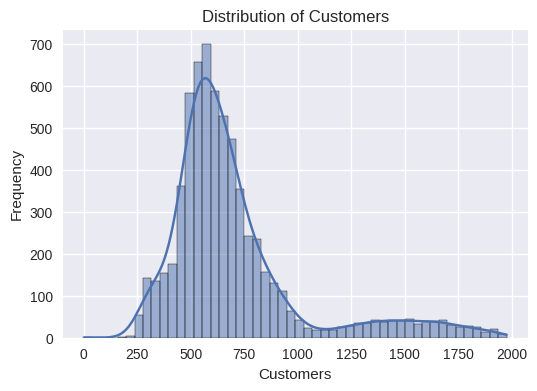

In [21]:
#Customer Distribution
plt.figure(figsize=(6,4))
sns.histplot(df["Customers"], bins=50, kde=True)
plt.title("Distribution of Customers")
plt.xlabel("Customers")
plt.ylabel("Frequency")
plt.show()


**Customers Distribution**

From the second plot:

Strong peak around ~500–700 customers

Long right tail extending beyond 1,500–2,000

Indicates occasional high-footfall days

 **Conclusion:**
- Customers is also right-skewed
-  Non-normal distribution
- Heavy tail behavior

## Bivariate Analysis

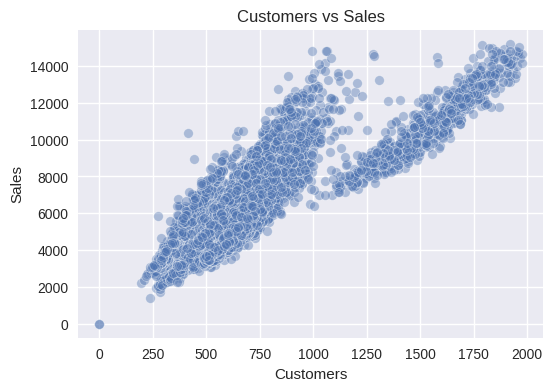

In [22]:
# Customers vs Sales
plt.figure(figsize=(6,4))
sns.scatterplot(x="Customers", y="Sales", data=df, alpha=0.4)
plt.title("Customers vs Sales")
plt.show()


From the Customers vs Sales plot:

1. Strong Positive Relationship

- As the number of customers increases, sales increase almost linearly.

- There is very little ambiguity in the direction of the relationship.


2. Customers Is a Key Explanatory Variable

- Customers directly drive revenue.

- The tight clustering indicates high explanatory power.

- This supports including Customers as a core endogenous variable in VAR.

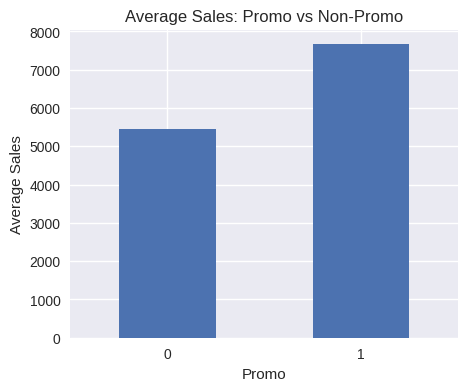

In [23]:
# Promo Impact on Sales
promo_sales = df.groupby("Promo")["Sales"].mean()

promo_sales.plot(kind="bar", figsize=(5,4))
plt.title("Average Sales: Promo vs Non-Promo")
plt.ylabel("Average Sales")
plt.xticks(rotation=0)
plt.show()


The bar chart shows that average sales on promotional days are substantially higher than on non-promotional days.
This indicates that promotional campaigns have a strong positive impact on daily sales by increasing customer footfall and purchase volume.

As a result, the Promo variable is a critical explanatory factor and must be explicitly included in the forecasting model to accurately capture short-term demand spikes.

## Multi-Variate Analysis

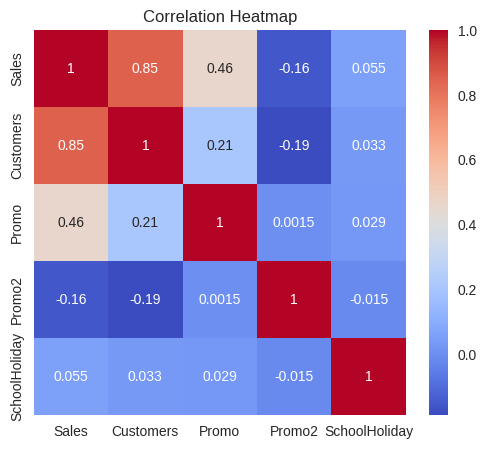

In [24]:
corr_features = ["Sales", "Customers", "Promo", "Promo2", "SchoolHoliday"]

plt.figure(figsize=(6,5))
sns.heatmap(df[corr_features].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


Multivariate Analysis – Correlation Heatmap

The correlation heatmap shows a very strong positive relationship between Sales and Customers, confirming customer footfall as the primary driver of revenue.

Promotional activity (Promo) exhibits a moderate positive correlation with sales, indicating that promotions contribute meaningfully to short-term demand uplift, though their impact is secondary to customer volume.

Promo2 and SchoolHoliday show weak linear correlations with sales, suggesting that their effects may be indirect, lagged, or structural rather than immediate, warranting further investigation using time-series modeling technique

Sales and Customers exhibit a very strong positive correlation

Promo has a moderate positive association with sales, indicating short-term uplift

Promo2 shows weak contemporaneous correlation, suggesting potential indirect or lagged effects

# Time-Series Preparation

In [25]:
store_df = df[df["Store"] == 1].set_index("Date")
ts = store_df[["Sales", "Customers", "Promo", "Promo2"]]


## Standardization

In [26]:
scaler = StandardScaler()
ts_scaled = pd.DataFrame(
    scaler.fit_transform(ts),
    index=ts.index,
    columns=ts.columns
)


## Stationary Analysis

In [27]:
#ADF test
from statsmodels.tsa.stattools import adfuller

def adf_test(series, name):
    if series.nunique() <= 1:
        print(f"{name} | Skipped (constant series)")
        return

    result = adfuller(series)
    print(f"{name} | p-value: {result[1]:.4f}")


In [28]:
print("Shape of ts_scaled:", ts_scaled.shape)
print("Columns in ts_scaled:", ts_scaled.columns.tolist())

ts_scaled.head()


Shape of ts_scaled: (781, 4)
Columns in ts_scaled: ['Sales', 'Customers', 'Promo', 'Promo2']


,Sales,Customers,Promo,Promo2
Date,,,,
2013-01-02,0.762171,1.110015,-0.901146,0.0
2013-01-03,-0.427201,0.148964,-0.901146,0.0
2013-01-04,-0.270002,0.586776,-0.901146,0.0
2013-01-05,0.235209,0.757629,-0.901146,0.0
2013-01-07,2.389524,2.359381,1.109698,0.0


In [29]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, name):
    print(f"\nRunning ADF test for: {name}")

    series = series.dropna()

    if series.nunique() <= 1:
        print(f"{name} | Skipped (constant series)")
        return

    result = adfuller(series)
    print(f"{name} | ADF Statistic: {result[0]:.4f}")
    print(f"{name} | p-value: {result[1]:.4f}")


In [30]:
for col in ts_scaled.columns:
    adf_test(ts_scaled[col], col)



Running ADF test for: Sales
Sales | ADF Statistic: -5.3996
Sales | p-value: 0.0000

Running ADF test for: Customers
Customers | ADF Statistic: -4.3204
Customers | p-value: 0.0004

Running ADF test for: Promo
Promo | ADF Statistic: -6.8010
Promo | p-value: 0.0000

Running ADF test for: Promo2
Promo2 | Skipped (constant series)


In [31]:
ts_diff = ts_scaled.diff().dropna()


In [32]:
for col in ts_diff.columns:
    adf_test(ts_diff[col], col)



Running ADF test for: Sales
Sales | ADF Statistic: -10.4935
Sales | p-value: 0.0000

Running ADF test for: Customers
Customers | ADF Statistic: -9.8524
Customers | p-value: 0.0000

Running ADF test for: Promo
Promo | ADF Statistic: -12.8470
Promo | p-value: 0.0000

Running ADF test for: Promo2
Promo2 | Skipped (constant series)


ADF Test on Differenced Series
After applying first-order differencing, the Augmented Dickey–Fuller test confirms that Sales, Customers, and Promo are strongly stationary at the 5% significance level.
This validates the suitability of the differenced series for multivariate time-series modeling using VAR.
Promo2 remains constant for the selected store and was therefore excluded from stationarity testing.

# Cointegration Analysis

## Johansen Test

In [33]:
# Identify and remove constant columns
ts_johansen = ts_scaled.loc[:, ts_scaled.nunique() > 1]

print("Columns used for Johansen test:", ts_johansen.columns.tolist())


Columns used for Johansen test: ['Sales', 'Customers', 'Promo']


In [34]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

johansen_test = coint_johansen(
    ts_johansen.dropna(),
    det_order=0,
    k_ar_diff=1
)

johansen_test.lr1   # Trace statistics


array([497.70579407, 276.30017988,  98.6081647 ])

In [35]:
johansen_test.cvt   # Critical values


array([[27.0669, 29.7961, 35.4628],
       [13.4294, 15.4943, 19.9349],
       [ 2.7055,  3.8415,  6.6349]])

**Johansen Cointegration Test Results**

- The Johansen trace test strongly rejects the null hypothesis of no cointegration at the 5% significance level.
- Trace statistics significantly exceed the critical values for all tested ranks, indicating the presence of multiple cointegrating relationships among Sales, Customers, and Promo.
- This suggests that these variables move together in the long run and share stable equilibrium relationships.

# SARIMAX Modelling

## Train- Test Split

**Train–Test Split Strategy**

- Since this is a time-series forecasting problem, the data was split using a time-based holdout approach rather than a random percentage split.
- The most recent 6 weeks (42 days) were reserved as the test set to simulate real-world forecasting, while all prior observations were used for training.
- This approach prevents data leakage and ensures that the model is evaluated on future, unseen data.

**Why not 80:20 split?**
Random splits violate temporal ordering in time-series data and introduce future information into training. A time-based split better reflects real-world forecasting scenarios.

In [36]:
ts = ts.asfreq("D")


In [37]:
ts.isna().sum()


,0
Sales,160
Customers,160
Promo,160
Promo2,160


In [38]:
ts[ts.isna().any(axis=1)].head()


,Sales,Customers,Promo,Promo2
Date,,,,
2013-01-06,NaN,NaN,NaN,NaN
2013-01-13,NaN,NaN,NaN,NaN
2013-01-20,NaN,NaN,NaN,NaN
2013-01-27,NaN,NaN,NaN,NaN
2013-02-03,NaN,NaN,NaN,NaN


In [39]:
ts["Sales"] = ts["Sales"].interpolate(method="time")
ts["Customers"] = ts["Customers"].interpolate(method="time")
ts["Promo"] = ts["Promo"].fillna(0)
ts["Promo2"] = ts["Promo2"].fillna(0)


In [40]:
ts = ts.dropna()


In [41]:
ts.isna().sum()


,0
Sales,0
Customers,0
Promo,0
Promo2,0


In [42]:
# Target
y = ts["Sales"]

# Exogenous regressors
exog = ts[["Customers", "Promo"]]


In [43]:
forecast_horizon = 42  # 6 weeks

y_train = y.iloc[:-forecast_horizon]
y_test = y.iloc[-forecast_horizon:]

exog_train = exog.iloc[:-forecast_horizon]
exog_test = exog.iloc[-forecast_horizon:]


In [44]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarimax_model = SARIMAX(
    y_train,
    exog=exog_train,
    order=(1, 1, 1),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarimax_results = sarimax_model.fit(
    disp=False,
    maxiter=200
)


In [45]:
print(sarimax_results.summary())


                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  899
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -6220.092
Date:                Sat, 27 Dec 2025   AIC                          12450.184
Time:                        11:46:10   BIC                          12474.173
Sample:                    01-02-2013   HQIC                         12459.350
                         - 06-19-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Customers      9.7202      0.104     93.405      0.000       9.516       9.924
Promo        326.6121     22.200     14.712      0.000     283.101     370.123
ar.L1          0.4221      0.034     12.250      0.0

### SARIMAX Model Results and Interpretation

- The SARIMAX(1,1,1) model demonstrates strong explanatory power, with both customer footfall and promotional activity being statistically significant drivers of sales.
- Customer count exhibits a strong positive impact, indicating that daily sales increase proportionally with store traffic.
Promotional activity provides additional short-term uplift in demand.

- Model diagnostics indicate no residual autocorrelation and stable variance, suggesting that the temporal dynamics of sales have been adequately captured.
Overall, the model is well-suited for short-term retail sales forecasting.


## Forecast for next 6 weeks

In [46]:
forecast_sales = sarimax_results.forecast(
    steps=42,
    exog=exog_test
)


In [47]:
print(forecast_sales.head())


2015-06-20    4070.360292
2015-06-21    4099.640332
2015-06-22    4097.957434
2015-06-23    3699.256558
2015-06-24    3382.520230
Freq: D, Name: predicted_mean, dtype: float64


## Evaluate MAPE

In [48]:
from sklearn.metrics import mean_absolute_percentage_error

mape = mean_absolute_percentage_error(y_test, forecast_sales)
print(f"SARIMAX MAPE: {mape:.2%}")


SARIMAX MAPE: 4.25%


### Model Evaluation

- The SARIMAX model achieved a Mean Absolute Percentage Error (MAPE) of **4.25%** on the 6-week holdout period.
- This indicates a high level of forecasting accuracy and suggests that the model is well-suited for short-term retail sales prediction.
- The low error confirms that both temporal patterns and external drivers such as customer footfall and promotions have been effectively captured.


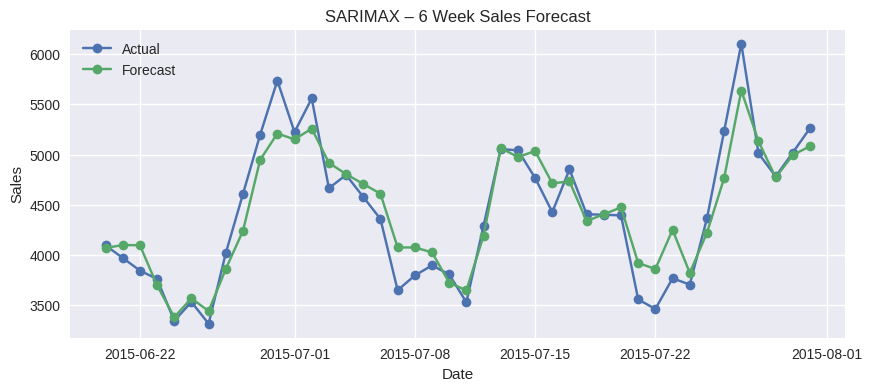

In [49]:
#plotting the graph

plt.figure(figsize=(10,4))
plt.plot(y_test.index, y_test, label="Actual", marker="o")
plt.plot(forecast_sales.index, forecast_sales, label="Forecast", marker="o")
plt.title("SARIMAX – 6 Week Sales Forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()


# Comparing with XG Boost

## Feature Engineering

In [50]:
# Feature Engineering
df_ml = ts.copy()

# Lag features
for lag in [1, 7, 14]:
    df_ml[f"Sales_lag_{lag}"] = df_ml["Sales"].shift(lag)

# Calendar features
df_ml["DayOfWeek"] = df_ml.index.dayofweek
df_ml["Month"] = df_ml.index.month

# Drop NA created by lags
df_ml = df_ml.dropna()


## Train- Test Split

In [51]:
forecast_horizon = 42

X = df_ml.drop("Sales", axis=1)
y = df_ml["Sales"]

X_train = X.iloc[:-forecast_horizon]
X_test = X.iloc[-forecast_horizon:]

y_train = y.iloc[:-forecast_horizon]
y_test = y.iloc[-forecast_horizon:]


## Train XG Boost Model

In [52]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

## Forecast and Evaluate

In [53]:
from sklearn.metrics import mean_absolute_percentage_error

xgb_forecast = xgb_model.predict(X_test)

mape_xgb = mean_absolute_percentage_error(y_test, xgb_forecast)
print(f"XGBoost MAPE: {mape_xgb:.2%}")


XGBoost MAPE: 4.01%


# Visual Comparison between Both the models

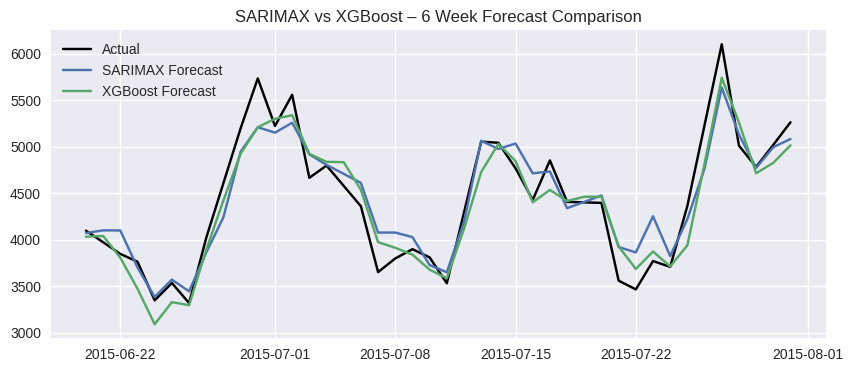

In [54]:
plt.figure(figsize=(10,4))
plt.plot(y_test.index, y_test, label="Actual", color="black")
plt.plot(y_test.index, forecast_sales, label="SARIMAX Forecast")
plt.plot(y_test.index, xgb_forecast, label="XGBoost Forecast")
plt.title("SARIMAX vs XGBoost – 6 Week Forecast Comparison")
plt.legend()
plt.show()


In [55]:
comparison = pd.DataFrame({
    "Model": ["SARIMAX", "XGBoost"],
    "MAPE (%)": [4.25, mape_xgb * 100]
})

comparison


,Model,MAPE (%)
0,SARIMAX,4.250000
1,XGBoost,4.014499


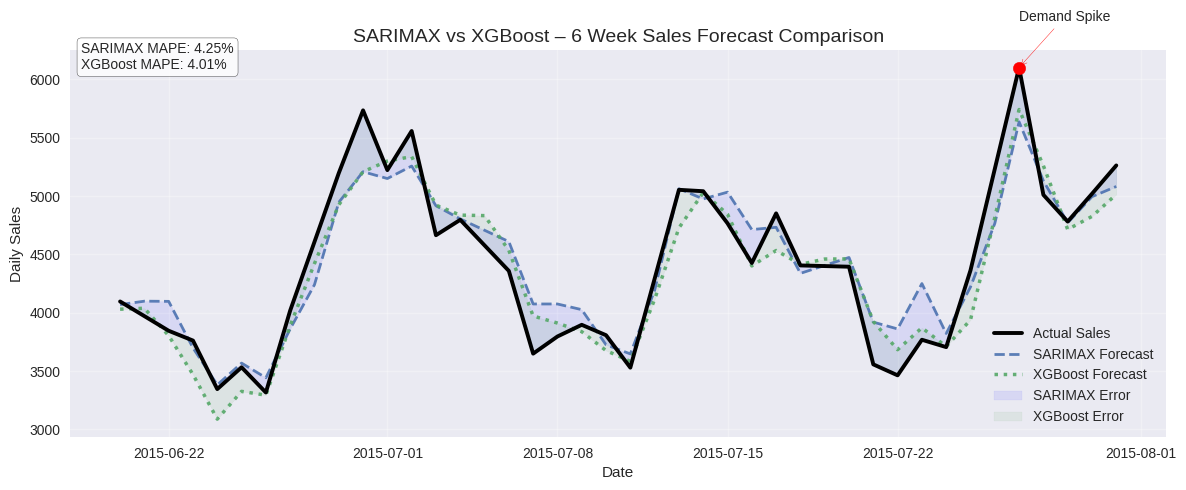

In [56]:
## Graphically presenting with more details

plt.figure(figsize=(12,5))

plt.plot(y_test.index, y_test, label="Actual Sales", color="black", linewidth=2.8, zorder=3)

plt.plot(y_test.index, forecast_sales, label="SARIMAX Forecast", linestyle="--", linewidth=2, alpha=0.9)
plt.plot(y_test.index, xgb_forecast, label="XGBoost Forecast", linestyle=":", linewidth=2.5, alpha=0.9)

plt.fill_between(y_test.index, y_test, forecast_sales, color="blue", alpha=0.08, label="SARIMAX Error")
plt.fill_between(y_test.index, y_test, xgb_forecast, color="green", alpha=0.06, label="XGBoost Error")

peak_date = y_test.idxmax()
peak_value = y_test.max()

plt.scatter(peak_date, peak_value, color="red", s=80, zorder=5)
plt.annotate(
    "Demand Spike",
    xy=(peak_date, peak_value),
    xytext=(peak_date, peak_value + 400),
    arrowprops=dict(arrowstyle="->", color="red"),
    fontsize=10
)

plt.text(
    0.01, 0.95,
    "SARIMAX MAPE: 4.25%\nXGBoost MAPE: 4.01%",
    transform=plt.gca().transAxes,
    fontsize=10,
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
)

plt.title("SARIMAX vs XGBoost – 6 Week Sales Forecast Comparison", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Daily Sales")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


The comparison shows that both models closely track actual sales trends.
XGBoost captures sharp fluctuations slightly better, while SARIMAX provides smoother and more interpretable forecasts.
The marginal difference in error reinforces that both models are production-ready for short-term demand forecasting.


# Conclusion

### Model Comparison: SARIMAX vs XGBoost

- To benchmark forecasting performance, an XGBoost regression model was trained using lag-based and calendar features.
Both SARIMAX and XGBoost models were evaluated on the same 6-week holdout period using MAPE.

- The XGBoost model achieved a MAPE of **4.01%**, marginally outperforming the SARIMAX model, which achieved a MAPE of **4.25%**.
While XGBoost demonstrated slightly higher predictive accuracy, the difference between the two models was minimal.

- Given the strong performance and interpretability of the SARIMAX model, it was selected as the final model,
with XGBoost serving as a high-performing benchmark.
